In [24]:
#!/usr/bin/env python
# coding: utf-8

# Facial Emotion Detection using CNN<br>
<br>
This script implements a Convolutional Neural Network (CNN) for facial emotion detection using the FER2013 dataset.

## 1. Import Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
import warnings
warnings.filterwarnings('ignore')

Check if GPU is available

In [28]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 2. Load and Explore the Dataset

Load the FER2013 dataset

In [29]:
data = pd.read_csv('fer2013.csv')
print(data.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


Check the shape of the dataset

In [30]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (35887, 3)


Check for missing values

In [31]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
emotion    0
pixels     0
Usage      0
dtype: int64


Check the distribution of emotions

In [32]:
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_label'] = data['emotion'].map(emotion_labels)

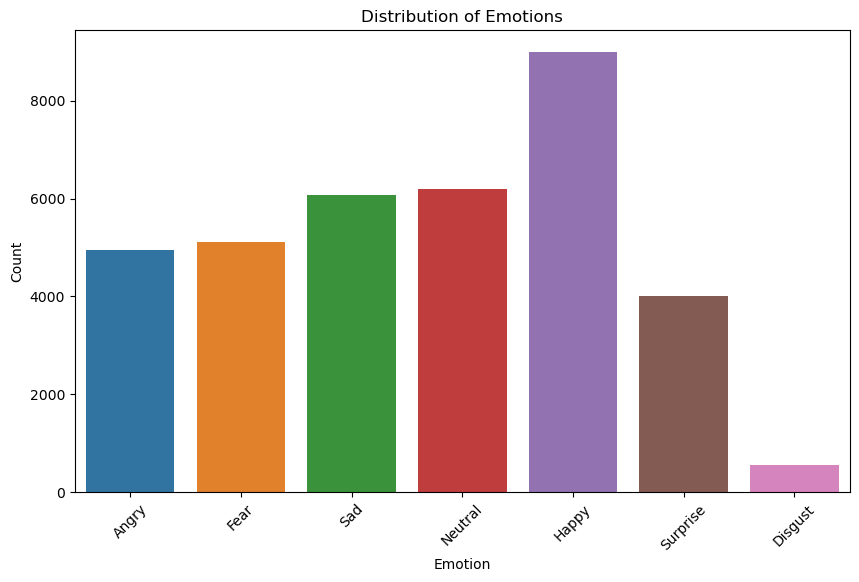

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion_label', data=data)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Print the count of each emotion

In [34]:
print(data['emotion_label'].value_counts())

emotion_label
Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: count, dtype: int64


## 3. Data Preprocessing

Function to preprocess the pixel data

In [35]:
def preprocess_data(data):
    # Extract features (pixel values) and labels (emotions)
    pixels = data['pixels'].tolist()
    emotions = data['emotion'].values
    
    # Convert pixel strings to numpy arrays
    X = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split()]
        face = np.array(face).reshape(48, 48)
        X.append(face)
    
    X = np.array(X)
    
    # Normalize pixel values to [0, 1]
    X = X / 255.0
    
    # Reshape for CNN input (add channel dimension)
    X = X.reshape(X.shape[0], 48, 48, 1)
    
    # Convert labels to one-hot encoding
    y = tf.keras.utils.to_categorical(emotions, num_classes=7)
    
    return X, y

Split the data into training, validation, and test sets

In [36]:
train_data = data[data['Usage'] == 'Training']
val_data = data[data['Usage'] == 'PublicTest']
test_data = data[data['Usage'] == 'PrivateTest']

In [37]:
print(f"Training set size: {train_data.shape[0]}")
print(f"Validation set size: {val_data.shape[0]}")
print(f"Test set size: {test_data.shape[0]}")

Training set size: 28709
Validation set size: 3589
Test set size: 3589


Preprocess the data

In [38]:
X_train, y_train = preprocess_data(train_data)
X_val, y_val = preprocess_data(val_data)
X_test, y_test = preprocess_data(test_data)

In [39]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (28709, 48, 48, 1)
y_train shape: (28709, 7)
X_val shape: (3589, 48, 48, 1)
y_val shape: (3589, 7)
X_test shape: (3589, 48, 48, 1)
y_test shape: (3589, 7)


## 4. Visualize Sample Images

Visualize some sample images

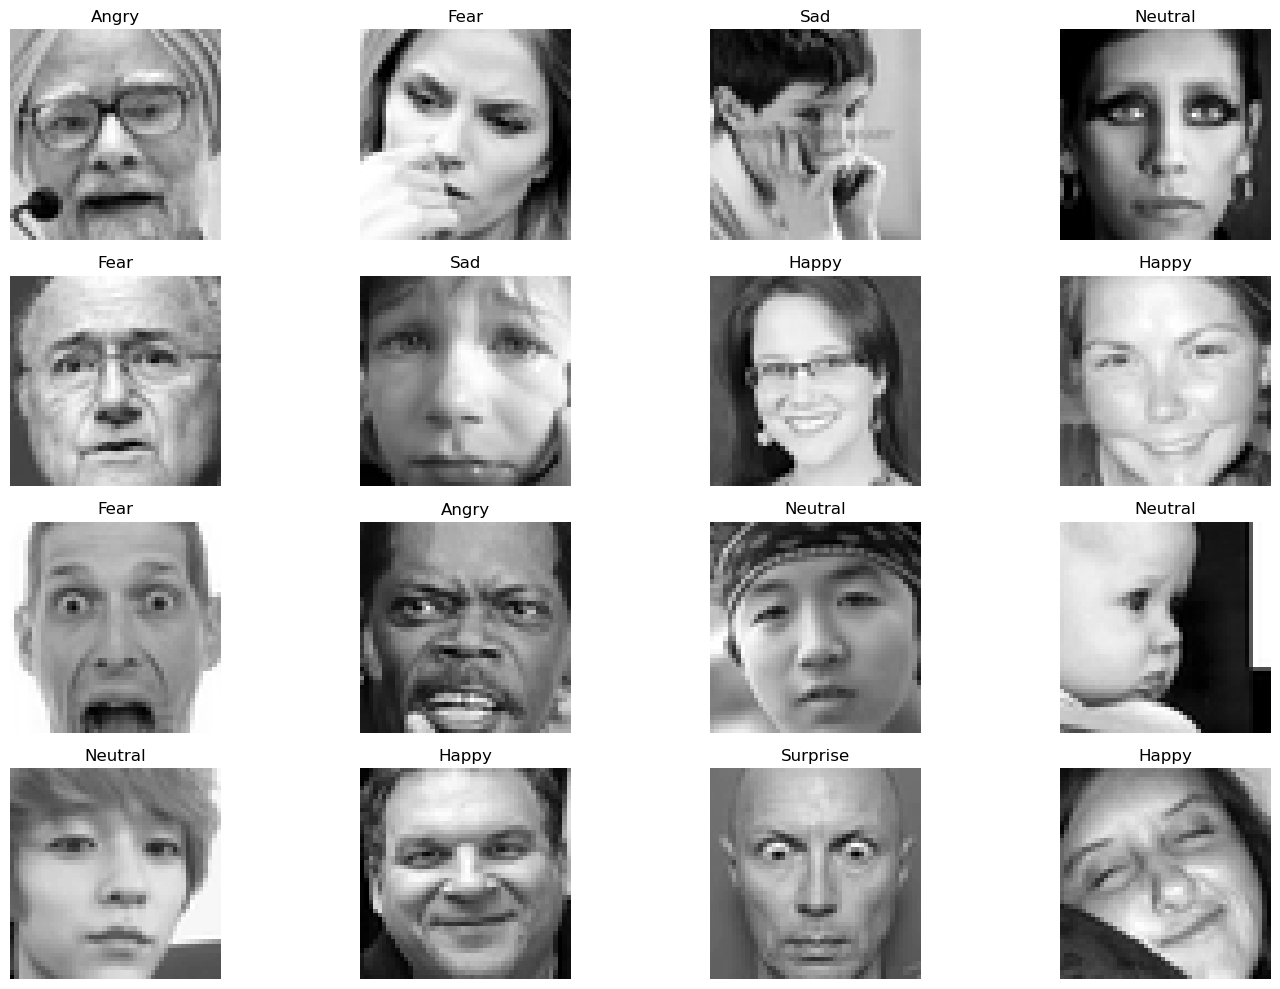

In [40]:
plt.figure(figsize=(15, 10))
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.imshow(X_train[i].reshape(48, 48), cmap='gray')
    plt.title(emotion_labels[np.argmax(y_train[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Data Augmentation

Create data generator for data augmentation

In [41]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [42]:
datagen.fit(X_train)

## 6. Build CNN Model

Build a CNN model

In [43]:
def build_model():
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second Convolutional Block
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Third Convolutional Block
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Create the model

In [44]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 687,079 (2.62 MB)

 Trainable params: 684,647 (2.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

## 7. Train the Model

Define callbacks

In [45]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [46]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [47]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

In [48]:
callbacks = [checkpoint, reduce_lr, early_stopping]

Train the model with data augmentation

In [49]:
batch_size = 64
epochs = 50

In [50]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.1914 - loss: 2.4923
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to best_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.1914 - loss: 2.4916 - val_accuracy: 0.2494 - val_loss: 1.8318 - learning_rate: 0.0010
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:01 137ms/step - accuracy: 0.2969 - loss: 1.8248

2025-03-09 11:56:37.009002: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_accuracy did not improve from 0.24937
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2969 - loss: 1.8248 - val_accuracy: 0.2491 - val_loss: 1.8299 - learning_rate: 0.0010
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2696 - loss: 1.8282
Epoch 3: val_accuracy improved from 0.24937 to 0.34299, saving model to best_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 64s 143ms/step - accuracy: 0.2696 - loss: 1.8281 - val_accuracy: 0.3430 - val_loss: 1.6346 - learning_rate: 0.0010
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:02 139ms/step - accuracy: 0.2969 - loss: 1.9651

2025-03-09 11:57:43.035336: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy did not improve from 0.34299
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2969 - loss: 1.9651 - val_accuracy: 0.3422 - val_loss: 1.6356 - learning_rate: 0.0010
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3495 - loss: 1.6444
Epoch 5: val_accuracy improved from 0.34299 to 0.40596, saving model to best_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 61s 137ms/step - accuracy: 0.3496 - loss: 1.6443 - val_accuracy: 0.4060 - val_loss: 1.5285 - learning_rate: 0.0010
Epoch 6/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:05 146ms/step - accuracy: 0.3281 - loss: 1.7119
Epoch 6: val_accuracy did not improve from 0.40596
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3281 - loss: 1.7119 - val_accuracy: 0.4060 - val_loss: 1.5379 - learning_rate: 0.0010
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3999 - loss: 1.5455
Epoch 7: val_accuracy improved from 0.40596 to 0.44051, saving model to best_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━

2025-03-09 11:59:57.158189: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_accuracy did not improve from 0.44051
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5156 - loss: 1.3154 - val_accuracy: 0.4397 - val_loss: 1.4126 - learning_rate: 0.0010
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4517 - loss: 1.4358
Epoch 9: val_accuracy improved from 0.44051 to 0.49512, saving model to best_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 68s 152ms/step - accuracy: 0.4517 - loss: 1.4358 - val_accuracy: 0.4951 - val_loss: 1.3056 - learning_rate: 0.0010
Epoch 10/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:12 161ms/step - accuracy: 0.5156 - loss: 1.4364
Epoch 10: val_accuracy did not improve from 0.49512
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5156 - loss: 1.4364 - val_accuracy: 0.4940 - val_loss: 1.3055 - learning_rate: 0.0010
Epoch 11/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4739 - loss: 1.3732
Epoch 11: val_accuracy improved from 0.49512 to 0.51463, saving model to best_model.keras
448/448 ━━━━━━━━━━━━━━━

2025-03-09 12:04:39.288594: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_accuracy did not improve from 0.54834
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4375 - loss: 1.3982 - val_accuracy: 0.5297 - val_loss: 1.2398 - learning_rate: 0.0010
Epoch 17/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5267 - loss: 1.2514
Epoch 17: val_accuracy did not improve from 0.54834
448/448 ━━━━━━━━━━━━━━━━━━━━ 69s 153ms/step - accuracy: 0.5267 - loss: 1.2514 - val_accuracy: 0.5467 - val_loss: 1.1942 - learning_rate: 0.0010
Epoch 18/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:10 158ms/step - accuracy: 0.4219 - loss: 1.4233
Epoch 18: val_accuracy did not improve from 0.54834
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4219 - loss: 1.4233 - val_accuracy: 0.5422 - val_loss: 1.2051 - learning_rate: 0.0010
Epoch 19/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5313 - loss: 1.2334
Epoch 19: val_accuracy improved from 0.54834 to 0.57175, saving model to best_model.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 69s 154ms/step - accuracy: 0.

2025-03-09 12:14:05.275848: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 32: val_accuracy did not improve from 0.60267
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6719 - loss: 0.9502 - val_accuracy: 0.5985 - val_loss: 1.0648 - learning_rate: 0.0010
Epoch 33/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5761 - loss: 1.1376
Epoch 33: val_accuracy did not improve from 0.60267
448/448 ━━━━━━━━━━━━━━━━━━━━ 68s 151ms/step - accuracy: 0.5761 - loss: 1.1376 - val_accuracy: 0.5456 - val_loss: 1.1849 - learning_rate: 0.0010
Epoch 34/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:10 158ms/step - accuracy: 0.4688 - loss: 1.4264
Epoch 34: val_accuracy did not improve from 0.60267
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4688 - loss: 1.4264 - val_accuracy: 0.5492 - val_loss: 1.1809 - learning_rate: 0.0010
Epoch 35/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5776 - loss: 1.1165
Epoch 35: val_accuracy did not improve from 0.60267
448/448 ━━━━━━━━━━━━━━━━━━━━ 67s 150ms/step - accuracy: 0.5776 - loss: 1.1165 - val_accuracy: 0.

## 8. Evaluate the Model

Plot training history

In [51]:
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

Plot accuracy

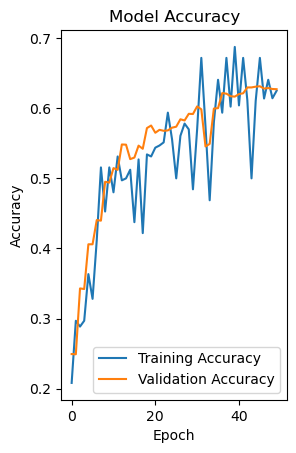

In [52]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Plot loss

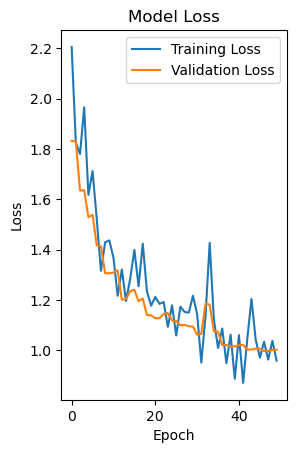

In [53]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [54]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

Load the best model

In [55]:
model.load_weights('best_model.keras')

Evaluate on test set

In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6289 - loss: 0.9604
Test Loss: 0.9651
Test Accuracy: 0.6367


Make predictions on test set

In [57]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


Classification report

In [58]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(emotion_labels.values())))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.52      0.58      0.55       491
     Disgust       0.59      0.18      0.28        55
        Fear       0.48      0.28      0.35       528
       Happy       0.86      0.86      0.86       879
         Sad       0.53      0.51      0.52       594
    Surprise       0.73      0.72      0.73       416
     Neutral       0.56      0.77      0.65       626

    accuracy                           0.64      3589
   macro avg       0.61      0.56      0.56      3589
weighted avg       0.63      0.64      0.63      3589



Confusion matrix

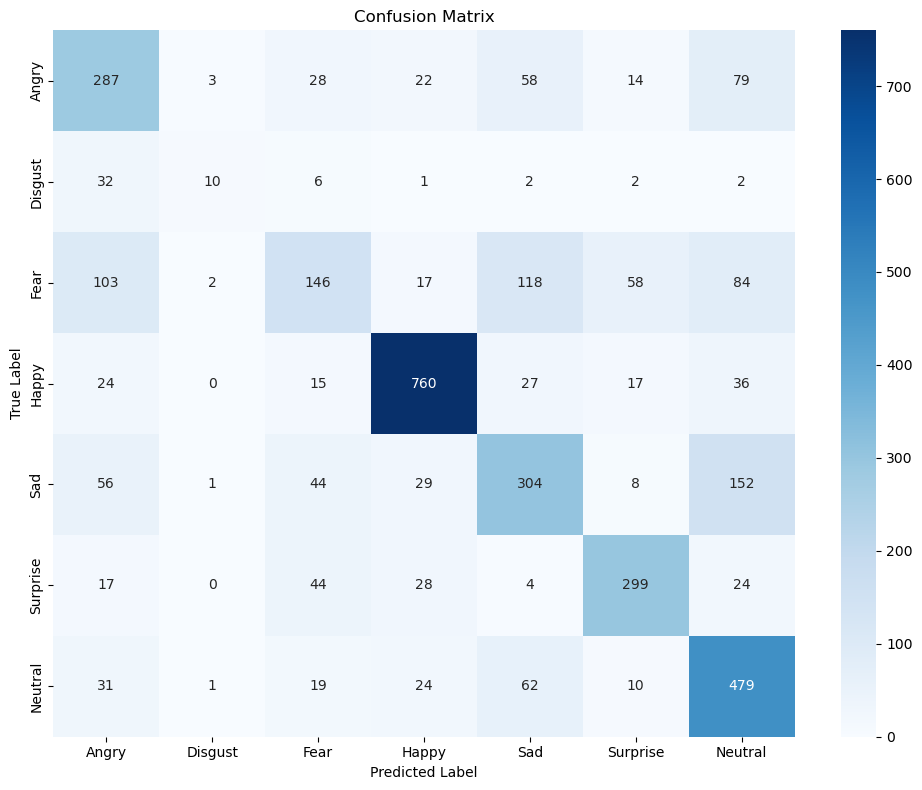

In [59]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(emotion_labels.values()),
            yticklabels=list(emotion_labels.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 9. Visualize Predictions

Visualize some predictions

In [60]:
def plot_predictions(X, y_true, y_pred, n=16):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(4, 4, i+1)
        plt.imshow(X[i].reshape(48, 48), cmap='gray')
        true_label = emotion_labels[np.argmax(y_true[i])]
        pred_label = emotion_labels[np.argmax(y_pred[i])]
        title = f"True: {true_label}\nPred: {pred_label}"
        if true_label == pred_label:
            color = 'green'
        else:
            color = 'red'
        plt.title(title, color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Get random indices from test set

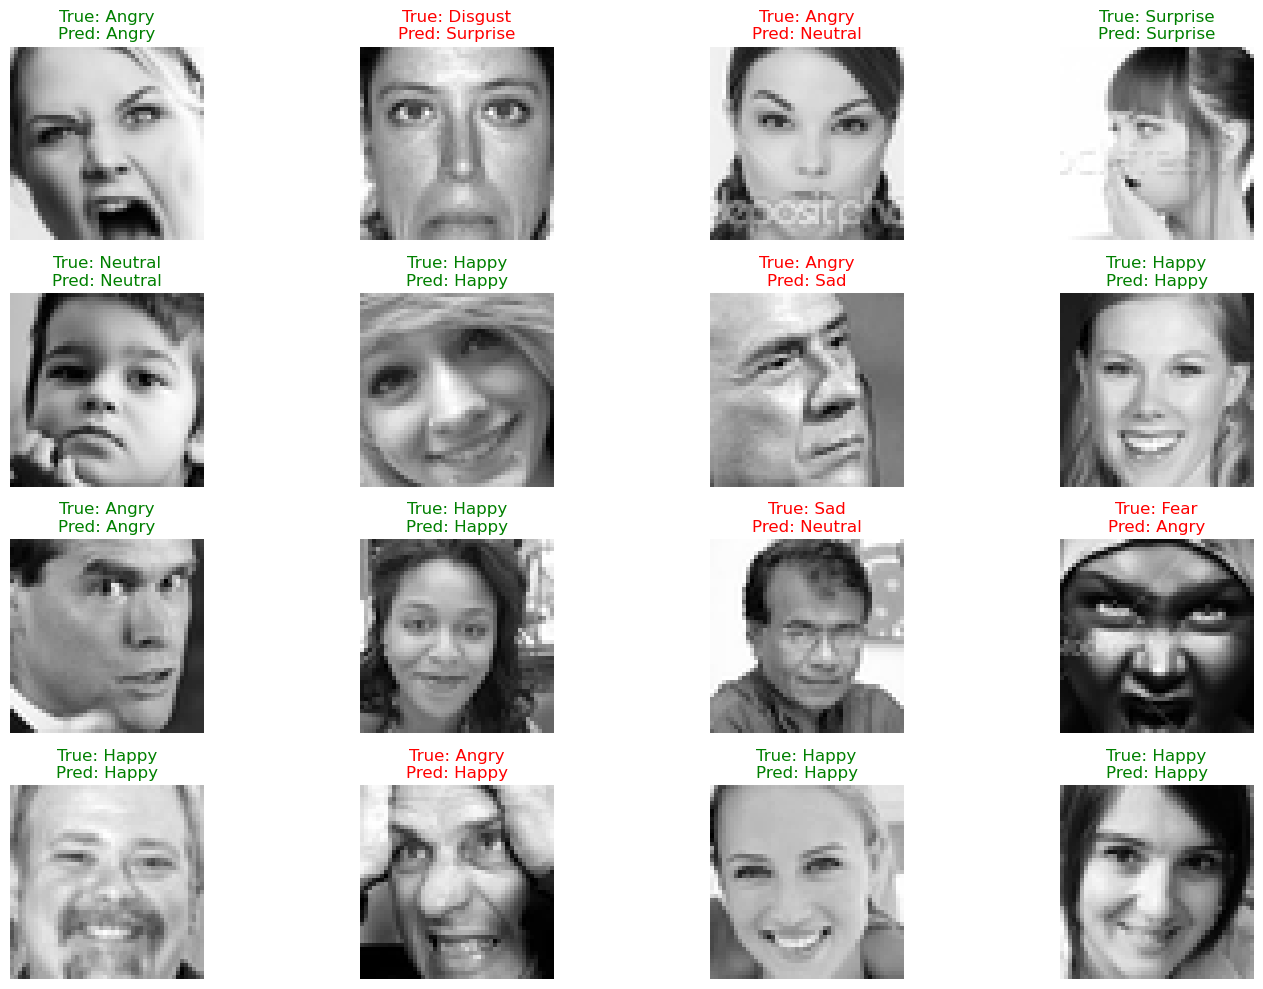

In [61]:
indices = np.random.randint(0, len(X_test), 16)
plot_predictions(X_test[indices], y_test[indices], y_pred[indices])

## 10. Save the Model

Save the model

In [62]:
model.save('facial_emotion_model.keras')
print("Model saved to 'facial_emotion_model.keras'")

Model saved to 'facial_emotion_model.keras'


In [65]:
model.save('facial_emotion_model.h5')
print("Model saved to 'facial_emotion_model.h5'")

Model saved to 'facial_emotion_model.h5'


## 11. Test with Custom Images (Optional)

Function to preprocess a custom image

In [63]:
def preprocess_image(image_path):
    # Read image
    img = cv2.imread(image_path, 0)  # Read as grayscale
    
    # Resize to 48x48
    img = cv2.resize(img, (48, 48))
    
    # Normalize
    img = img / 255.0
    
    # Reshape for model input
    img = img.reshape(1, 48, 48, 1)
    
    return img

Function to predict emotion

In [64]:
def predict_emotion(image_path):
    # Preprocess image
    img = preprocess_image(image_path)
    
    # Make prediction
    prediction = model.predict(img)[0]
    emotion_idx = np.argmax(prediction)
    emotion = emotion_labels[emotion_idx]
    confidence = prediction[emotion_idx] * 100
    
    # Display image and prediction
    img_display = cv2.imread(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Emotion: {emotion}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()
    
    # Print all emotion probabilities
    for i, emotion_name in emotion_labels.items():
        print(f"{emotion_name}: {prediction[i]*100:.2f}%")

Example usage (uncomment when you have a custom image)<br>
predict_emotion('path_to_your_image.jpg')

## 12. Conclusion and Next Steps<br>
<br>
In this script, we've built a CNN model for facial emotion detection using the FER2013 dataset. <br>
The model architecture includes multiple convolutional layers with batch normalization and dropout for regularization.<br>
<br>
To improve the model further, consider:<br>
<br>
1. **More complex architectures**: Try deeper networks or pre-trained models like VGG, ResNet, or EfficientNet.<br>
2. **Advanced data augmentation**: Implement more sophisticated augmentation techniques.<br>
3. **Class imbalance handling**: Address the imbalance in the dataset using techniques like class weights or oversampling.<br>
4. **Hyperparameter tuning**: Experiment with different learning rates, batch sizes, and optimizers.<br>
5. **Ensemble methods**: Combine multiple models for better performance.<br>
6. **Transfer learning**: Use pre-trained models on larger face datasets and fine-tune on FER2013.<br>
<br>
Remember that achieving over 90% accuracy on this dataset is challenging, as even human accuracy on FER2013 is estimated to be around 65-70%. 